In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x  #gpu
except Exception:
  pass

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input #https://static.packt-cdn.com/products/9781788629416/graphics/B08956_02_10.jpg
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import sigmoid, tanh, softplus
from tensorflow.python.keras.utils.generic_utils import get_custom_objects

from keras.datasets import cifar100
from keras.utils import np_utils

In [0]:

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [0]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [0]:
NUM_CLASSES = 100

cifar_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

In [0]:
x_train2 = x_train/255
x_test2 = x_test/255

y_train_processed = np_utils.to_categorical(y_train,NUM_CLASSES)
y_test_processed = np_utils.to_categorical(y_test,NUM_CLASSES)

In [0]:
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

def mish(x):
    return x*tanh(softplus(x))

get_custom_objects().update({'swish': Activation(swish), 'mish': Activation(mish)})

In [0]:
def make_model():
    model = Sequential()
    model.add(Conv2D(128, 3, padding ='same', activation = 'mish', input_shape = (32, 32, 3)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))
    model.add(Conv2D(64, 3, padding ='same', activation = 'mish'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))
    model.add(Conv2D(32, 3, padding ='same', activation = 'mish'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dense(256))
    model.add(Dense(256))
    
    model.add(Dense(NUM_CLASSES, activation = 'softmax'))
    return model

In [0]:
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 100-way classification
    optimizer='adam', 
    metrics=['accuracy']  # report accuracy during training
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 32)         

In [0]:
batch_size = 64
epochs = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x_train2, y_train_processed,  # prepared data
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test2, y_test_processed),
    shuffle=True,
    callbacks=[callback],
)

ValueError: ignored

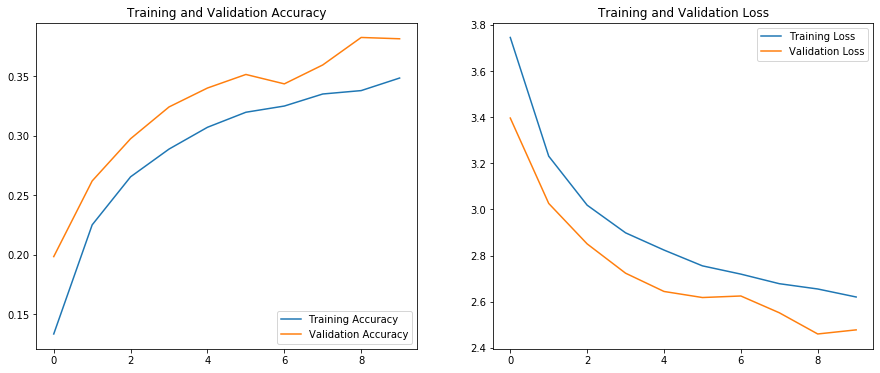

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

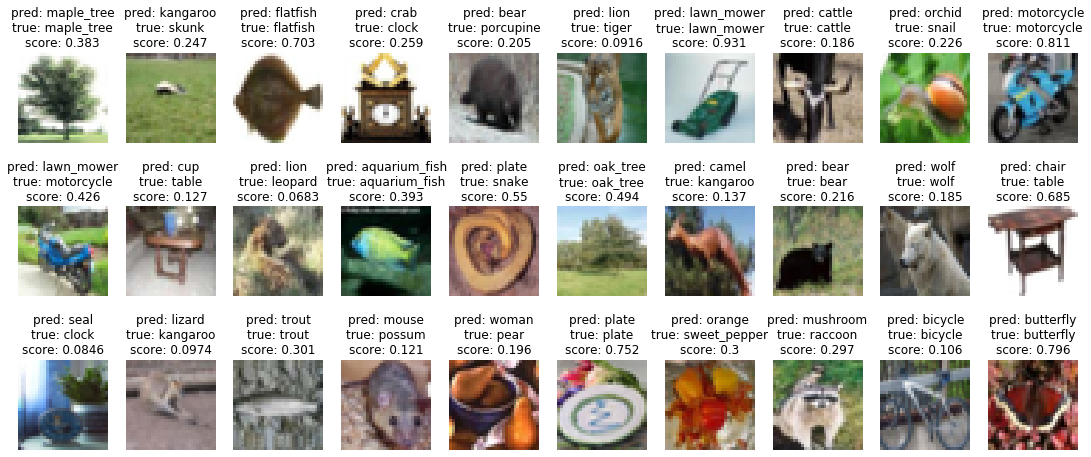

In [0]:
cols = 10
rows = 3
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label =  cifar_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\ntrue: {}\nscore: {:.3}".format(
               pred_label, true_label, pred_proba
        ))
plt.show()

In [0]:
x_train3 = preprocess_input(x_train)
x_test3 = preprocess_input(x_test)

In [0]:
def make_model_transfer():
    resnet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in resnet_model.layers:
        if isinstance(layer, BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

    model = Sequential()
    model.add(UpSampling2D(size=(7,7)))
    model.add(resnet_model)
    model.add(GlobalAveragePooling2D()) #https://alexisbcook.github.io/assets/global_average_pooling.png
    model.add(Dense(256, activation='mish'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization()) #https://forums.fast.ai/uploads/default/original/2X/9/998a1be6463260f731481106756034c42040e256.jpg
    model.add(Dense(100, activation='softmax'))
    return model

In [0]:
model = make_model_transfer()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 100-way classification
    optimizer='adam', 
    metrics=['accuracy']  # report accuracy during training
)

94674944/94668760 [==============================] - 1s 0us/step


In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

history = model.fit(
    x_train3, y_train_processed,  # prepared data
    batch_size=64,
    epochs=1,
    validation_data=(x_test3, y_test_processed),
    callbacks=[callback],
)

Train on 50000 samples, validate on 10000 samples
50000/50000 [==============================] - 213s 4ms/sample - loss: 1.6152 - acc: 0.5732 - val_loss: 1.0011 - val_acc: 0.7080


In [0]:
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

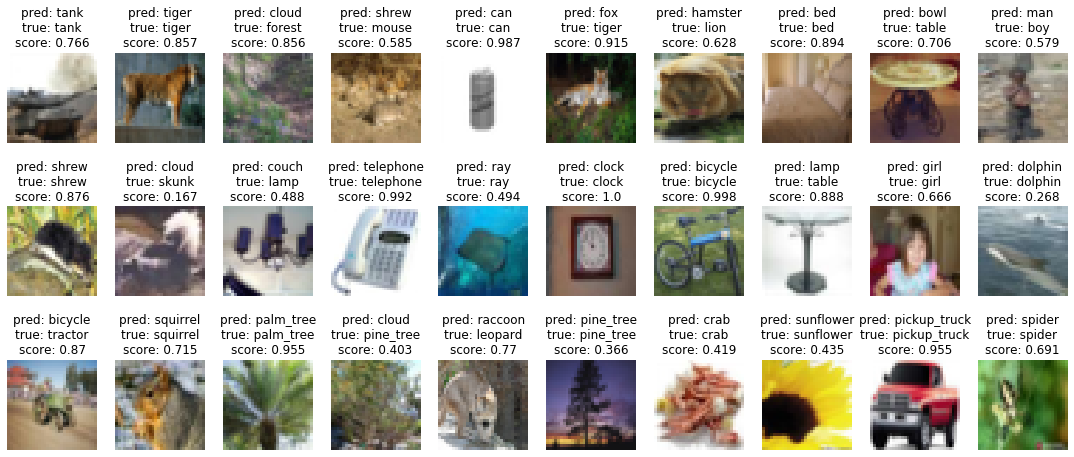

In [0]:
cols = 10
rows = 3
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label =  cifar_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\ntrue: {}\nscore: {:.3}".format(
               pred_label, true_label, pred_proba
        ))
plt.show()

**KIỂM TRA BẰNG HÌNH ẢNH TỰ CHỌN**

In [0]:
import cv2
im = cv2.imread("/content/2992f1bb-a9d8-4674-afd2-f20c85b0a70f.jpeg")
im2 = cv2.resize(im,(32,32))

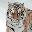

In [0]:
from google.colab.patches import cv2_imshow
cv2_imshow(im2)

In [0]:
im2_processed = preprocess_input(im2)
im2_processed = np.reshape(im2_processed, (1, 32, 32, 3))

In [0]:
#predict, output class of new image